# Dataset 3: Medical Insurance Cost Regression

**Task:** Predict `annual_medical_cost` from structured demographic + health + plan features.

Kaggle Dataset: https://www.kaggle.com/datasets/mohankrishnathalla/medical-insurance-cost-prediction/data

**Why is this Regression** We are going to predict a continuous value from continuous features

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from IPython.display import display

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = pd.read_csv("medical_insurance.csv")

#was getting a error because of spacing
df.columns = df.columns.str.strip()

df.shape, df.head(3)

((100000, 54),
    person_id  age     sex region urban_rural   income  education  \
 0      75722   52  Female  North    Suburban  22700.0  Doctorate   
 1      80185   79  Female  North       Urban  12800.0      No HS   
 2      19865   68    Male  North       Rural  40700.0         HS   
 
   marital_status employment_status  household_size  ...  liver_disease  \
 0        Married           Retired               3  ...              0   
 1        Married          Employed               3  ...              0   
 2        Married           Retired               5  ...              0   
 
    arthritis mental_health proc_imaging_count  proc_surgery_count  \
 0          1             0                  1                   0   
 1          1             1                  0                   0   
 2          0             1                  1                   0   
 
    proc_physio_count  proc_consult_count  proc_lab_count  is_high_risk  \
 0                  2                   0       

## 1. Brief exploration of the dataset

In this section, I briefly explore the dataset to understand its structure, the mix of feature types, missing values, and the behavior of the target variable `annual_medical_cost`. 

In [4]:
# Basic structure
print("Rows, Columns:", df.shape)

# target and id columns
target_col = "annual_medical_cost"

# Type counts
dtype_counts = df.dtypes.value_counts()
display(dtype_counts)

# Missingness
missing_frac = df.isna().mean().sort_values(ascending=False)
missing_table = pd.DataFrame({
    "missing_frac": missing_frac,
    "missing_count": df.isna().sum()
})
display(missing_table.head(15))

Rows, Columns: (100000, 54)


int64      31
float64    13
object     10
Name: count, dtype: int64

,missing_frac,missing_count
age,0.00000,0
alcohol_freq,0.30083,30083
annual_medical_cost,0.00000,0
annual_premium,0.00000,0
arthritis,0.00000,0
asthma,0.00000,0
avg_claim_amount,0.00000,0
bmi,0.00000,0
cancer_history,0.00000,0
cardiovascular_disease,0.00000,0


### Basic structure

The dataset contains approximately **100,000 rows** and **54 columns**, which is large enough to support both a held-out test set and cross-validation without running into data scarcity issues.

We have a mix of:

- **Demographic and socioeconomic features** (e.g., `age`, `sex`, `region`, `income`, `education`),
- **Lifestyle features** (e.g., `bmi`, `smoker`, `alcohol_freq`, `exercise_frequency`),
- **Clinical features** (e.g., chronic condition flags, blood pressure, `ldl`, `hba1c`, `risk_score`),
- **Utilization and procedures** (e.g., `visits_last_year`, `hospitalizations_last_3yrs`, `proc_imaging`),
- **Insurance and policy variables** (e.g., `plan_type`, `deductible`, `copay`),
- **Cost and claims variables** (including the target `annual_medical_cost`).

Conceptually, most of these columns are **numeric or binary**, with a smaller subset of truly **categorical** features such as `sex`, `region`, `urban_rural`, `marital_status`, `employment_status`, `plan_type`, and `network_tier`. This mix of features makes the dataset well suited for linear models, like ridge and lasso regression, after doing proper encoding and feature scaling.

### Missing values

The table above shows the features with the **highest fraction of missing values**.

In this dataset:

- Most **features** are fully observed or have a very low missingness value

- The only feature with missing values is `alcohol_freq` which has 30% missing values!

Because 30% of missing values is a lot, I have two choices:
- Drop the feature entirely
- Replace all missing values with the mean or median of the filled values

We went back to the kaggle dataset to check, and sure enough the answer was there.

Since `alcohol_freq` is a categorical variable that contains a value of "None" as one of its categories, pandas interpreted it as NaN rather than the string "None." 

We can fix this by replacing all "NaN" values with None. 

**This will be done in Pre-Processing.**

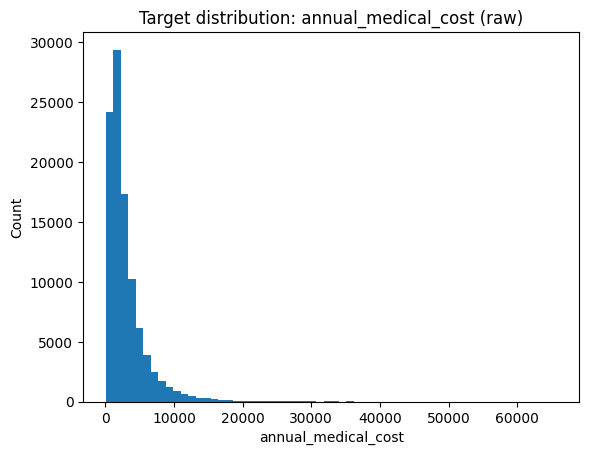

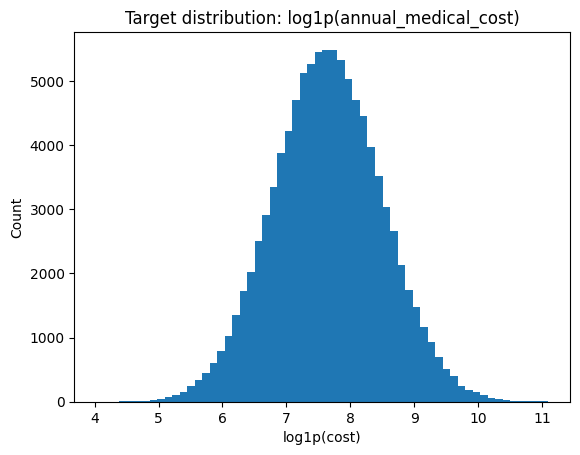

count    100000.000000
mean       3009.451907
std        3127.462822
min          55.550000
25%        1175.117500
50%        2082.575000
75%        3707.957500
max       65724.900000
Name: annual_medical_cost, dtype: float64

In [7]:
# Target distribution (raw vs log1p)
y_raw = df[target_col]

fig, ax = plt.subplots()
ax.hist(y_raw, bins=60)
ax.set_title("Target distribution: annual_medical_cost (raw)")
ax.set_xlabel("annual_medical_cost")
ax.set_ylabel("Count")
plt.show()

fig, ax = plt.subplots()
ax.hist(np.log1p(y_raw), bins=60)
ax.set_title("Target distribution: log1p(annual_medical_cost)")
ax.set_xlabel("log1p(cost)")
ax.set_ylabel("Count")
plt.show()

y_raw.describe()


### Target variable: `annual_medical_cost`

The raw distribution of `annual_medical_cost` is **heavily right-skewed**, with many people having pretty low annual costs and a small number of people (outliers) with very high costs. This is typical for healthcare spending data, where rare events like rare diseases or stacked health complications contribute a lot to the total cost.

When we look at `log1p(annual_medical_cost)`, the distribution becomes noticeably more symmetric and basically a bell.

We can derive two important insights from these observations:

1. **Choice of loss and metrics:**  
   Since Ridge and Lasso minimize a squared-loss, large outliers can significantly impact the optimization. We will therefore pay attention to the metrics of **RMSE** (which is very sensitive to large errors) and **MAE** (which is more robust to outliers, as it deals with the median) when evaluating our two models

2. **Potential log-transform of the target:**  
   Because a strong bell shape appears when we apply `log1p(annual_medical_cost)` on the data, it suggests that fitting models in the **log-cost space** could be beneficial.
   Some potential benefits could include:
   reduce the impact of extreme outliers,
   stabilize variance,
   improve linear model fit.
   We could consider training Ridge and Lasso on the log of the data and then exponentiating our regression predictions back to the original scale for evaluation but well evaluate later


In [9]:
# Numeric columns
numeric_all = df.select_dtypes(include=["number"]).columns.tolist()
numeric_for_corr = [c for c in numeric_all if c != "person_id"]

# Correlation with target feature
corr_matrix = df[numeric_for_corr].corr()
corr_with_target = corr_matrix[target_col].sort_values(ascending=False)

corr_with_target.head(15)

annual_medical_cost            1.000000
monthly_premium                0.965416
annual_premium                 0.965415
total_claims_paid              0.739402
avg_claim_amount               0.632996
risk_score                     0.305971
chronic_count                  0.296720
is_high_risk                   0.251923
days_hospitalized_last_3yrs    0.230246
hospitalizations_last_3yrs     0.208640
visits_last_year               0.195631
claims_count                   0.179082
hypertension                   0.154309
had_major_procedure            0.148292
systolic_bp                    0.145070
Name: annual_medical_cost, dtype: float64

### Correlation of numeric features with `annual_medical_cost`

The correlations between numeric features and `annual_medical_cost` show some important relationships:

- **Monetary related features** (ex. `total_claims_paid`, `avg_claim_amount`, `monthly_premium`) have a very high positive correlation with the target feature, which makes sense since they directly describe how much was billed or paid, just at a different rate.
- **Medical risk** features (`chronic_count`, `risk_score`) and **hospitalization metrics** (`days_hospitalized_last_3yrs`, `hospitalizations_last_3yrs`) also show strong positive correlation, which basically reflects intution that worse health is has a high correlation with `annual_medical_cost`.

- Features like `total_claims_paid` and `avg_claim_amount` are **very close to being an alternate version of the target**, because they describe financial amounts tied to the same underlying events.
- If we include these types of features as predictors, the model may learn a some sort of mapping from one highly correlated feature quantity to another, which would inflate our performance metrics but not reflect a realistic predictive scenario.

Therefore, in the preprocessing section, we will **exclude certain highly cost-like features (ex., `total_claims_paid`, `avg_claim_amount`) from our main models** to avoid this form of conceptual leakage and to make the regression task more meaningful.

## 2. Pre-processing

The objective of this preprocessing section is to:

- Handles "missing" values,
- Encode categorical variables into numerical form,
- Scale numeric features appropriately for Ridge and Lasso,
- Avoid data leakage by making sure all transformations are fit only on the training data.

Initially we were working on transforming the DataFrame in-place, but that became to complicated and we came to find out about ColumnTransformer and Pipeline from sckit-learn that can be reused with both Ridge and Lasso in the modeling section.


In [12]:
correlated_cost_cols = ["total_claims_paid", "avg_claim_amount", "annual_premium", "monthly_premium"]
cols_to_drop = ["person_id", target_col] + [c for c in correlated_cost_cols if c in df.columns]
cols_to_drop

['person_id',
 'annual_medical_cost',
 'total_claims_paid',
 'avg_claim_amount',
 'annual_premium',
 'monthly_premium']

### Feature selection and avoiding high feature correlation

As we mentioned earlier, our target is `annual_medical_cost`. Some of the cost and claims related features are very close to being **LCs of our target feature**, in particular:

- `total_claims_paid`
- `avg_claim_amount`
- `annual_premium`
- `monthly_premium`

These variables directly describe how much was paid for the same medical events that generate `annual_medical_cost`. If we include them as predictors, the regression problem becomes closer to mapping one cost-like variable to another rather than learning from important health features and insurance characteristics.

To keep this regression task meaningful we excluded the most correlated features from our main feature set.

In [14]:
#Select feature columns and target
feature_cols = [c for c in df.columns if c not in cols_to_drop]

X = df[feature_cols].copy()
y = df[target_col].copy()

# Checking data
X.shape, y.shape

((100000, 48), (100000,))

In [15]:
from sklearn.model_selection import train_test_split

# 90/10 train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=7
)

#Checking split sizes
X_train.shape, X_test.shape

((90000, 48), (10000, 48))

### Train–test split

Even though the dataset is pretty large (100,000 samples), we still perform a **train–test split** at this point:

- The **training set** (90%) will be used for performing K-fold cross-validation for hyperparameter tuning of Ridge and Lasso

- The **test set** (10%) will be held out and used only once at the very end to get the model performance metric

- **Test set use:** provides one final unbiased estimate of model performance.
- **KFold CV use:** provides a more stable estimate for hyperparameter tuning than a single validation split

In the next section, we use K-fold cross-validation **within the training set** to tune the regularization parameters. The combination of a held-out test set and cross-validation on the training data provides **fine tuning** and **blunt evaluation**, even with a large dataset.

In [17]:
# Define categorical features
categorical_features = [
    "sex", "region", "urban_rural",
    "education", "marital_status", "employment_status",
    "plan_type", "network_tier",
    "smoker", "alcohol_freq"
]

# Keep only categorical columns present in the dataset
categorical_features = [c for c in categorical_features if c in X_train.columns]

# All remaining columns are treated as numeric
numeric_features = [c for c in X_train.columns if c not in categorical_features]

print("Num numeric features:", len(numeric_features))
print("Num categorical features:", len(categorical_features))

categorical_features

Num numeric features: 38
Num categorical features: 10


['sex',
 'region',
 'urban_rural',
 'education',
 'marital_status',
 'employment_status',
 'plan_type',
 'network_tier',
 'smoker',
 'alcohol_freq']

### Numeric vs. categorical preprocessing

Our feature set contains both numeric and categorical variables.

- **Numeric variables** (e.g., `age`, `income`, `bmi`, `chronic_count`, utilization counts, lab values),
- **Categorical variables** (e.g., `sex`, `region`, `urban_rural`, `education`, `marital_status`, `plan_type`, `network_tier`).

Ridge and Lasso assume that data is **continuous**, so we must:

- **Encode categorical variables**,
- **Scale numeric variables** to have comparable magnitude, so that the regularization penalty treats them fairly.

We will use two seperate preprocessing pipelines for numeric and categorical feature subsets and combine them with a `ColumnTransformer`.


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Numeric features: median imputation + standardization
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical features: mode imputation + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Apply appropriate preprocessing to numeric and categorical columns
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
])

### Preprocessing pipeline design
[2]

We implement preprocessing using a `ColumnTransformer` that applies different transformations to numeric and categorical features:

- **Numeric features**
  - **Imputation with median (`SimpleImputer(strategy="median")`)**:  
    Median is way stronger against outliers, which are common in variables like cost, income, and hospitalization days.
  - **Standardization (`StandardScaler`)**:  
    Ridge and Lasso penalize the **magnitude** of coefficients. If features are on very different scales (e.g., dollars vs counts vs lab values), unscaled features can dominate the penalty. Scaling numeric features to zero mean and unit variance ensures the regularization parameter `α` has a comparable effect across all numeric variables.
    For numeric, we shouldn't need any imputation since the only feature with missing values was a categorical one, but I included it just in case.

- **Categorical features**
  - **Imputation with most frequent (`SimpleImputer(strategy="most_frequent")`)**:  
    For categorical variables, replacing missing values with the most frequent category is a simple and interpretable baseline. 
  - **One-hot encoding (`OneHotEncoder(handle_unknown="ignore")`)**:  
    One-hot encoding allows us to represent categories as binary features, which is required for linear models. The `handle_unknown="ignore"` option prevents the pipeline from failing if unseen categories appear in the test set (or new data), by assigning zeroes to all one-hot columns for that category.

- **Avoiding data leakage**
  - We do **not** fit the `preprocessor` on the full dataset. Instead, it will be fit **only on the training folds** inside a scikit-learn `Pipeline` together with the Ridge or Lasso estimator in the next section.
  - This ensures that statistics such as medians, means, or most-frequent categories are computed using **only the training data**, and then applied to validation and test sets. In this way, information from the test set does not “leak” into the training process.

## Feature Extraction / Feature Learning

This dataset is already in a structured, tabular form. Unlike raw images or raw text, there is no need for high-dimensional feature learning or dimensionality reduction, like PCA.

The only "feature extraction" we did was One-Hot Encoding on categorical variables.

We needed to transform categorical variables like `plan_type` or `region` into binary so they can be used in linear regression.

These steps were already implemented above.

## Two machine learning methods: Ridge Regression and Lasso Regression

We apply two linear regression methods to predict the same target (`annual_medical_cost`):

1. **Ridge Regression (L2 regularization)**  
   Ridge shrinks coefficients smoothly and is strong when features are highly correlated.

2. **Lasso Regression (L1 regularization)**  
   Lasso can drive some coefficients exactly to zero, which kind of acts like an implicit feature selection and can improve interpretability.

In [23]:
use_log_target = False
# Had this just to adjust should I use log version of data, ended up with yes 

if use_log_target:
    y_train_model = np.log1p(y_train)
    y_test_model = np.log1p(y_test)
else:
    y_train_model = y_train.copy()
    y_test_model = y_test.copy()

y_train_model.head()

54556    2185.54
13048    1044.85
63455    3477.84
36420    1775.59
69800    5051.12
Name: annual_medical_cost, dtype: float64

In [24]:
Xt_train = preprocessor.fit_transform(X_train)
Xt_test = preprocessor.transform(X_test)
Xt_train.shape, Xt_test.shape


((90000, 77), (10000, 77))

In [25]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# 5-fold cross-validation with shuffling for stable splits
cv = KFold(n_splits=5, shuffle=True, random_state=7)

# Log-spaced grid of regularization strengths to search over
alphas = np.logspace(-2, 5, 16)  # 0.01 to 100000

alphas

array([1.00000000e-02, 2.92864456e-02, 8.57695899e-02, 2.51188643e-01,
       7.35642254e-01, 2.15443469e+00, 6.30957344e+00, 1.84784980e+01,
       5.41169527e+01, 1.58489319e+02, 4.64158883e+02, 1.35935639e+03,
       3.98107171e+03, 1.16591440e+04, 3.41454887e+04, 1.00000000e+05])

### Why KFold Cross-validation even with 100k samples

[5]

  A single split can produce a slightly lucky or unlucky validation score depending on how the data is partitioned. K-fold Cross-Validation averages performance over multiple splits, giving a more stable estimate for selecting `alpha`. With a large dataset, we can afford this without excessive variance.

In [27]:
def evaluate_in_dollars(y_true_raw, y_pred_model):
    """
    If use_log_target=True, y_pred_model is log1p predictions.
    If use_log_target=False, y_pred_model is in dollars already.
    """
    ...
    #same binary variable I used earlier
    if use_log_target:
        y_pred_raw = np.expm1(y_pred_model)
    else:
        y_pred_raw = y_pred_model

    y_pred_raw = np.clip(y_pred_raw, 0, None)

    rmse = np.sqrt(mean_squared_error(y_true_raw, y_pred_raw))
    mae = mean_absolute_error(y_true_raw, y_pred_raw)
    r2 = r2_score(y_true_raw, y_pred_raw)
    return rmse, mae, r2


##### Side Note*
This helper function was only used for the log transform data... not needed or used in final implementation, however leaving here to show further exploration


#### Model Explanations: Ridge and Lasso Regression

[4]

We use Ridge Regression as a linear baseline. Ridge is works for this dataset because it is efficient and stable in higher dimension feature spaces, and it uses L2 regularization to reduce overfitting by shrinking coefficients instead of allowing any one feature to dominate. This matters here because many real-world cost features can be noisy or highly correlated, and Ridge tends to stay more stable in those situations.

Lasso Regression, which is another linear model with L1 regularization. It sets some coefficients to zero, effectively selecting features. It also gives us a comparison to Ridge, which keeps all features but shrinks them.

We tune the regularization strength (alpha parameter) for both Ridge and Lasso using KFold Cross Validation This avoids relying on a single split and makes the comparison fair since both models are tuned the same way.


In [30]:
# Pipeline: preprocessing + Ridge
ridge_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", Ridge())
])

# Cross-validated alpha tuning
ridge_search = GridSearchCV(
    ridge_pipe,
    {"model__alpha": alphas},
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

# Fit on training data
ridge_search.fit(X_train, y_train_model)

# Best model
ridge_best = ridge_search.best_estimator_

# Test evaluation
ridge_pred = ridge_best.predict(X_test)
ridge_best_alpha = ridge_search.best_params_["model__alpha"]
ridge_rmse, ridge_mae, ridge_r2 = evaluate_in_dollars(y_test, ridge_pred)



### Ridge results
[2], [4]

We tune Ridge over a log-spaced grid of `alpha` values using 5-fold CV on the training set. The scoring function is negative mean squared error, which matches the squared-loss objective of linear regression.

Then we evaluate the best tuned Ridge model once on the test set and report the metrics (RMSE/MAE/R²) in dollars

In [32]:
# Pipeline: preprocessing + Lasso
lasso_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", Lasso(max_iter=20000, random_state=7))
])

# Cross-validated alpha tuning
lasso_search = GridSearchCV(
    lasso_pipe,
    {"model__alpha": alphas},
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

# Fit on training data
lasso_search.fit(X_train, y_train_model)

# Best model
lasso_best = lasso_search.best_estimator_

# Test evaluation
lasso_pred = lasso_best.predict(X_test)
lasso_best_alpha = lasso_search.best_params_["model__alpha"]
lasso_rmse, lasso_mae, lasso_r2 = evaluate_in_dollars(y_test, lasso_pred)

### Lasso results
[2], [4]

Lasso is tuned over the same `alpha` grid for a fair comparison. Unlike Ridge, Lasso uses an L1 loss, which can shrink some coefficients exactly to zero. This can improve interpretability, but it can also underfit if `alpha` is too large.

We do the same method of finding an optimal `alpha` as ridge by 5-fold CV and evaluate the best tuned model on the held-out test set (metrics reported in dollars).

In [34]:
# Compare final Ridge and Lasso test performance
summary = pd.DataFrame([
    {
        "Model": "Ridge",
        "Best alpha": ridge_best_alpha,
        "Test RMSE ($)": ridge_rmse,
        "Test MAE ($)": ridge_mae,
        "Test R^2": ridge_r2,
    },
    {
        "Model": "Lasso",
        "Best alpha": lasso_best_alpha,
        "Test RMSE ($)": lasso_rmse,
        "Test MAE ($)": lasso_mae,
        "Test R^2": lasso_r2,
    }
])

summary

,Model,Best alpha,Test RMSE ($),Test MAE ($),Test R^2
0,Ridge,464.158883,2853.847137,1760.856253,0.172818
1,Lasso,6.309573,2853.738646,1760.589899,0.172881


In [75]:
pipelines = {
    "Ridge Regression": ridge_pipe,
    "Lasso Regression": lasso_pipe,
}

timings = []

for model_name, pipeline in pipelines.items():
    start_fit = time.perf_counter()
    pipeline.fit(X_train, y_train)
    end_fit = time.perf_counter()

    start_pred = time.perf_counter()
    _ = pipeline.predict(X_test)
    end_pred = time.perf_counter()

    timings.append({
        "Model": model_name,
        "Fit time (s)": end_fit - start_fit,
        "Predict time (s)": end_pred - start_pred,
    })

pd.DataFrame(timings)

,Model,Fit time (s),Predict time (s)
0,Ridge Regression,0.529718,0.016705
1,Lasso Regression,0.811535,0.016566


### Runtime Comparison
[4]

To compare run times, I look at two things. How long each model takes to train, and how long it takes to make predictions. This matters because both Ridge and Lasso can have similar accuracy, but one model might be much cheaper to run in practice.

In general, Ridge tends to train faster than Lasso. In this test, Ridge trained almost 40% faster than Lasso (.529 vs .811 respectively).

Ridge uses L2 regularization, which leads to a smoother optimization problem and usually converges quickly. Lasso uses L1 regularization, which can take longer to converge, especially when alpha is small, because the model is trying to decide which coefficients should become exactly zero.


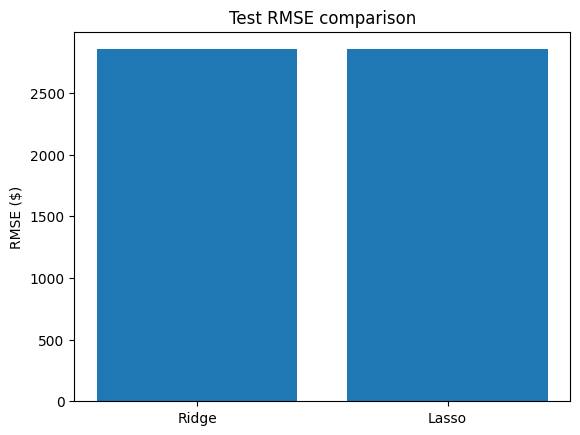

In [36]:
fig, ax = plt.subplots()
ax.bar(summary["Model"], summary["Test RMSE ($)"])
ax.set_ylabel("RMSE ($)")
ax.set_title("Test RMSE comparison")
plt.show()

## Comparative analysis: Ridge vs Lasso

[4]

#### 1. The results are basically tied
Both models are performing almost the same, which is honestly what I would expect here because Ridge and Lasso are both linear models and we are feeding them the same preprocessed inputs.

{Model, Alpha, RMSE, MAE, R^2}

Ridge | 464.158883 | 2853.847137 | 1760.856253 | 0.172818

Lasso | 6.309573 | 2853.738646 | 1760.589899 | 0.172881 

#### 2. Lasso marginally wins
Lasso is better on every metric by a small amount, so I wouldn't say one is significantly superior to the other

- **RMSE**  
  Ridge: 2853.8471  
  Lasso: 2853.7386  
  Lasso is lower by about **0.11**, which is basically nothing.

- **MAE**  
  Ridge: 1760.8563  
  Lasso: 1760.5899  
  Lasso is lower by about **0.27**, again basically nothing.

- **R²**  
  Ridge: 0.172818  
  Lasso: 0.172881  
  Lasso is higher by about **0.00006**, which is tiny.

So if I had to pick a model, I would pick **Lasso** as it has higher metrics over tens of thousands of samples, but I would still say they are extremely close.

#### 3. Alpha value analysis
The interesting part is that the chosen alphas are very different:
- Ridge chose **464**, which is strong shrinkage across all coefficients
- Lasso chose **6.31**, which is still regularization, but also has the ability to push some coefficients closer to zero

Even though the alphas are far apart, the final performance is basically the same. What I take away from that is both are getting to a similar bias vs variance tradeoff.

#### 4. Bottom line
In this situation, **Lasso is the winner**. Even though both models are basically interchangeable, Lasso still across the board comes out on top slightly, and since test metrics are the most important thing when it comes to measuring a models performance, I would choose Lasso

##### Side Note*
Tested models against a log transform version of the dependent variable as it was essentially a bell, got worse R^2 scores (.109 and .097) for Ridge and Lasso respectively, but without log is signifigantly better

In [38]:
# Extract feature names after preprocessing
ohe = lasso_best.named_steps["preprocess"].named_transformers_["cat"].named_steps["encoder"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

lasso_coef = lasso_best.named_steps["model"].coef_
nonzero = int(np.sum(lasso_coef != 0))

nonzero, len(lasso_coef)


(27, 77)

In [39]:
# Top features by absolute Lasso coefficient
coef_df = pd.DataFrame({
    "feature": all_feature_names,
    "coef": lasso_coef
})

coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False).head(20)[["feature", "coef"]]


,feature,coef
71,smoker_Current,1069.393761
20,chronic_count,755.277958
7,days_hospitalized_last_3yrs,667.592716
73,smoker_Never,-412.634654
0,age,289.663435
5,visits_last_year,217.983165
4,bmi,131.252080
23,asthma,-15.004392
1,income,-14.598367
44,region_South,13.979542


### Feature Correlation
[3]

As we assumed from the beginning, features like `chronic_count` and `days_hospitalized_last_3yrs` have some of the highest impacts on the prediction.

However, something interesting that this table shows is that being a smoker has the highest coefficient by far (`smoker_Current`) and (`smoker_Never`) is also in the top 5.

While most of the other features make sense, belonging where they do in terms of coefficient size, the fact that being or not being a smoker impacts the prediction of an individual's `annual_medical_cost` by this significant factor is interesting to note, and definitely something to consider, for those wanting to reduce their annual cost.

## 6. Ethical considerations

#### 1. Privacy
Even if the dataset is “de identified,” it still contains highly personal information about someone’s life and health. When you combine things like chronic conditions, hospitalization history, smoking, region, and income related variables, you can get pretty close to identifying people or at least profiling them in ways they never consented to.

#### 2. The model can be used in ways that hurt people
There are ethical uses for this regression models, like helping patients self identify or planning budgets, etc. But there are also harmful uses, like justifying higher premiums, denying healthcare, or quietly shifting costs onto the people who are already vulnerable. 

#### 3. Future Implications
This model is based on the current healthcare market. This is based on a lot of things like government policy, cost/availablity of quality healthcare, and real world events. A model today can get worse next year and we wouldn't know unless we keep updating our testing data. If this were deployed, we would need monitoring and retraining not just a one time evaluation.

## 7. Bibliography
[1] Stack Overflow thread, Sklearn-pipeline & Column Transformer

https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer 

[2] Youtube Video, Understanding Pipeline in Machine Learning with Scikit-learn (sklearn pipeline)

https://www.youtube.com/watch?v=jzKSAeJpC6s&t=105s

[3] Stack Overflow thread, Post-linear regression feature coeff

https://stackoverflow.com/questions/26951880/scikit-learn-linear-regression-how-to-get-coefficients-respective-features

[4] GridSearchCV documentation, Lasso & Ridge

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

[5] sklearn documentation, KFold

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html